<a href="https://colab.research.google.com/github/geotrush/Neural-Network-Zoo/blob/main/PyTorch/Image%2BVideo%2BAudio-Synthesis/Style-Transfer/Fast%20Neural%20Style%20Transfer%20with%20MSG-Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fast Neural Style Transfer with MSG-Net
-----------------------------------------
### Paper: [Multi-style Generative Network for Real-time Transfer (Zhang & Dana., 2017)](https://arxiv.org/pdf/1703.06953.pdf)

### GitHub: [PyTorch Implementation of Fast Neural Style Transfer with MSG-Net (Zhang & Dana., 2017)](https://github.com/zhanghang1989/PyTorch-Multi-Style-Transfer)

- Import libraries

In [ ]:
# Notebook display
from PIL import Image
from google.colab import files
import matplotlib.pyplot as plt
from IPython.display import clear_output

# PyTorch
import torch
from torchvision import transforms
from torch.nn import Module, Parameter, Sequential, Upsample, ReflectionPad2d, Conv2d, InstanceNorm2d, ReLU

- Define constants and image processing functions

In [ ]:
# Image size
SIZE = 1280

# Determine device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Pre-processing
def prep(image, size=SIZE, keep_aspect_ratio=False, to_tensor=False, device=DEVICE):
    image = image.convert('RGB')
    if keep_aspect_ratio:
        size2 = int(size / image.size[0] * image.size[1])
        image = image.resize((size, size2), Image.LANCZOS)
    else:
        image = image.resize((size, size), Image.LANCZOS)
    if to_tensor:
        image2tensor = transforms.Compose([transforms.ToTensor(),
                                           transforms.Lambda(lambda x: x[torch.LongTensor([2, 1, 0])]),
                                           transforms.Lambda(lambda x: x.mul_(255))])
        return image2tensor(image).unsqueeze(0).to(device)
    else:
        return image

# Post-processing
def post(tensor):
    tensor = tensor.detach().cpu().squeeze(0).clamp_(0, 255)
    tensor2image = transforms.Compose([transforms.Lambda(lambda x: x.div_(255)),
                                       transforms.Lambda(lambda x: x[torch.LongTensor([2, 1, 0])]),
                                       transforms.ToPILImage()])
    return tensor2image(tensor)

# Draw content, style and output images
def draw(input, content_image, style_image):
    output = post(input)

    clear_output(wait=True)
    plt.figure(figsize=(18, 6))

    ax1 = plt.subplot(1, 3, 1)
    ax1.imshow(prep(content_image, keep_aspect_ratio=True))
    ax1.axis('off')
    ax1.set_title('Content Image')

    ax2 = plt.subplot(1, 3, 2)
    ax2.imshow(prep(style_image, keep_aspect_ratio=True))
    ax2.axis('off')
    ax2.set_title('Style Image')

    ax3 = plt.subplot(1, 3, 3)
    ax3.imshow(output)
    ax3.axis('off')
    ax3.set_title('Output Image')

    plt.show()
    return output

- Upload content image and download one of [21 style images](https://github.com/zhanghang1989/PyTorch-Multi-Style-Transfer/tree/master/experiments/images/21styles)

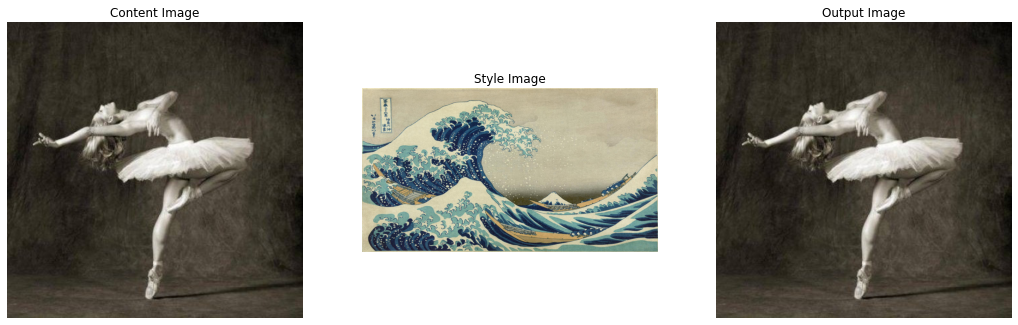

In [ ]:
# Manually upload the content image
files.upload()

# Download one of 21 style images
!wget https://raw.githubusercontent.com/zhanghang1989/PyTorch-Multi-Style-Transfer/master/experiments/images/21styles/wave.jpg

# Open and prepare images
content_image, style_image = Image.open('ballerina.jpg'), Image.open('wave.jpg')
content, style = prep(content_image, keep_aspect_ratio=True, to_tensor=True), prep(style_image, to_tensor=True)

# Display images
_ = draw(content, content_image, style_image)

- Define MSG-Net with nearest neighbour upsampling, instead of transposed convolutions, for better performance

In [ ]:
class CoMatchLayer(Module):
    def __init__(self, channels, batch_size=1):
        super().__init__()

        self.C = channels
        self.weight = Parameter(torch.FloatTensor(1, channels, channels), requires_grad=True)
        self.GM_t = torch.FloatTensor(batch_size, channels, channels).requires_grad_()

        # Weight Initialization
        self.weight.data.uniform_(0.0, 0.02)

    def set_targets(self, GM_t):
        self.GM_t = GM_t

    def forward(self, x):
        self.P = torch.bmm(self.weight.expand_as(self.GM_t), self.GM_t)
        return torch.bmm(self.P.transpose(1, 2).expand(x.size(0), self.C, self.C), x.view(x.size(0), x.size(1), -1)).view_as(x)


class ConvBlock(Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=False):
        super().__init__()

        self.upsample = Upsample(scale_factor=2) if upsample else None
        self.padding = ReflectionPad2d(kernel_size // 2) if kernel_size // 2 else None
        self.conv = Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        if self.upsample:
            x = self.upsample(x)
        if self.padding:
            x = self.padding(x)
        return self.conv(x)


class ResBlock(Module):

    expansion = 4

    def __init__(self, in_channels, channels, stride=1, downsample=False, upsample=False):
        super().__init__()

        self.down_conv = Conv2d(in_channels, channels * self.expansion, kernel_size=1, stride=stride) if downsample else None
        self.up_conv = ConvBlock(in_channels, channels * self.expansion, kernel_size=1, stride=1, upsample=upsample) if upsample else None

        self.conv_block = Sequential(InstanceNorm2d(in_channels), ReLU(),
                                     Conv2d(in_channels, channels, kernel_size=1, stride=1),
                                     InstanceNorm2d(channels), ReLU(),
                                     ConvBlock(channels, channels, kernel_size=3, stride=stride, upsample=upsample),
                                     InstanceNorm2d(channels), ReLU(),
                                     Conv2d(channels, channels * self.expansion, kernel_size=1, stride=1))

    def forward(self, x):
        residual = x
        if self.down_conv:
            residual = self.down_conv(x)
        if self.up_conv:
            residual = self.up_conv(x)
        return self.conv_block(x) + residual


class MSGNet(Module):
    def __init__(self, in_channels=3, out_channels=3, channels=128, num_res_blocks=6):
        super().__init__()

        # Siamese Network
        self.siamese_network = Sequential(ConvBlock(in_channels, 64, kernel_size=7, stride=1),
                                          InstanceNorm2d(64), ReLU(),
                                          ResBlock(64, 32, stride=2, downsample=True),
                                          ResBlock(32 * ResBlock.expansion, channels, stride=2, downsample=True))

        # CoMatch Layer
        self.comatch_layer = CoMatchLayer(channels * ResBlock.expansion)

        # Transformation Network
        self.transformation_network = Sequential(self.siamese_network,
                                                 self.comatch_layer,
                                                 *[ResBlock(channels * ResBlock.expansion, channels) for _ in range(num_res_blocks)],
                                                 ResBlock(channels * ResBlock.expansion, 32, stride=1, upsample=True),
                                                 ResBlock(32 * ResBlock.expansion, 16, stride=1, upsample=True),
                                                 InstanceNorm2d(16 * ResBlock.expansion), ReLU(),
                                                 ConvBlock(16 * ResBlock.expansion, out_channels, kernel_size=7, stride=1))

    def gram_matrix(self, inputs):
        BS, C, H, W = inputs.size()
        inputs = inputs.view(BS, C, H * W)
        GM = inputs.bmm(inputs.transpose(1, 2))
        return GM.div_(C * H * W)

    def set_targets(self, x):
        targets = self.siamese_network(x)
        GM_t = self.gram_matrix(targets)
        self.comatch_layer.set_targets(GM_t)

    def forward(self, x):
        return self.transformation_network(x)

- Load MSG-Net weights & biases pre-trained on [21 style images](https://github.com/zhanghang1989/PyTorch-Multi-Style-Transfer/tree/master/experiments/images/21styles)


In [ ]:
msgnet = MSGNet().to(DEVICE)

!wget -O msgnet_21_styles.model https://www.dropbox.com/s/2iz8orqqubrfrpo/21styles.model?dl=1

state = msgnet.state_dict()
new_state = torch.load('msgnet_21_styles.model')
new_state_copy = new_state.copy()

for key, value in new_state_copy.items():
    if key.endswith(('running_mean', 'running_var')):
        del new_state[key]

new_state_values = list(new_state.values())

for i, key in enumerate(state):
    state[key] = new_state_values[i]

msgnet.load_state_dict(state)
torch.save(state, 'msgnet_21_styles.pth')

- Transfer style

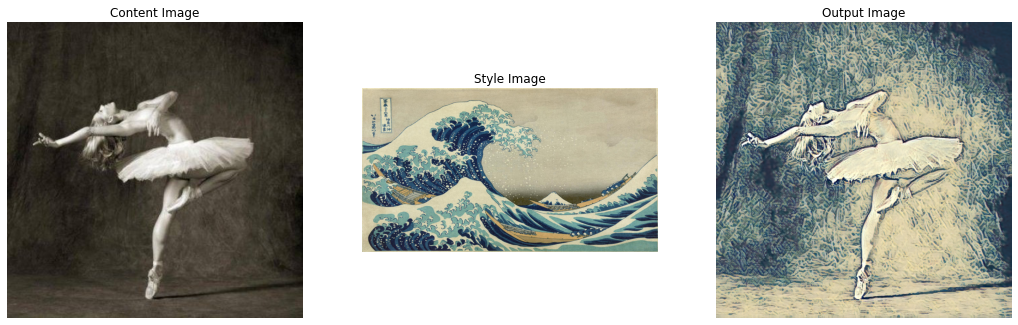

CPU times: user 38.1 s, sys: 2.26 s, total: 40.3 s
Wall time: 40.5 s


In [ ]:
%%time

def transfer_style(msgnet, content):
    msgnet.eval()
    with torch.no_grad():
        output = draw(msgnet(content), content_image, style_image)
    return output

# Pre-compute targets
msgnet.set_targets(style)

# Run
output = transfer_style(msgnet, content)

- Save and download output

In [ ]:
output.save('output.png')
files.download('output.png')